----
### Import Libraries
First, import all the necessary public libraries as well as a few classes from the `torchsig` toolkit. An additional import from the `cm_plotter.py` helper script is also done here to retrieve a function to streamline plotting of confusion matrices.

# Example 02 - Sig53 Classifier
This notebook walks through a simple example of how to use the clean Sig53 dataset, load a pre-trained supported model, and evaluate the trained network's performance. Note that the experiment and the results herein are not to be interpreted with any significant value but rather serve simply as a practical example of how the `torchsig` dataset and tools can be used and integrated within a typical [PyTorch](https://pytorch.org/) and/or [PyTorch Lightning](https://www.pytorchlightning.ai/) workflow.

In [1]:
from torchsig.models.iq_models.efficientnet.efficientnet import efficientnet_b4
from pytorch_lightning.callbacks import ModelCheckpoint
from torchsig.utils.cm_plotter import plot_confusion_matrix
from pytorch_lightning import LightningModule, Trainer
from sklearn.metrics import classification_report
from torchsig.datasets.sig53 import Sig53
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F
import torchsig.transforms as ST
import numpy as np
import torchsig
import torch
import os

----
### Instantiate Sig53 Dataset
Here, we instantiate the Sig53 clean training dataset and the Sig53 clean validation dataset. We demonstrate how to compose multiple TorchSig transforms together, using a data impairment with a random phase shift that uniformly samples a phase offset between -1 pi and +1 pi. The next transform normalizes the complex tensor, and the final transform converts the complex data to a real-valued tensor with the real and imaginary parts as two channels. We additionally provide a target transform that maps the `SignalDescription` objects, that are part of `SignalData` objects, to a desired format for the model we will train. In this case, we use the `DescToClassIndex` target transform to map class names to their indices within an ordered class list. Finally, we sample from our datasets and print details in order to confirm functionality.

For more details on the Sig53 dataset instantiations, please see the Sig53 example notebook.

In [2]:
# Specify Sig53 Options
root = "sig53/"
train = True
impaired = False
class_list = list(Sig53._idx_to_name_dict.values())
transform = ST.Compose([
    ST.RandomPhaseShift(phase_offset=(-1, 1)),
    ST.Normalize(norm=np.inf),
    ST.ComplexTo2D(),
])
target_transform = ST.DescToClassIndex(class_list=class_list)

# Instantiate the Sig53 Clean Training Dataset
sig53_clean_train = Sig53(
    root=root,
    train=train,
    impaired=impaired,
    transform=transform,
    target_transform=target_transform,
    use_signal_data=True,
)

# Instantiate the Sig53 Clean Validation Dataset
train = False
sig53_clean_val = Sig53(
    root=root,
    train=train,
    impaired=impaired,
    transform=transform,
    target_transform=target_transform,
    use_signal_data=True,
)

# Retrieve a sample and print out information to verify
idx = np.random.randint(len(sig53_clean_train))
data, label = sig53_clean_train[idx]
print("Dataset length: {}".format(len(sig53_clean_train)))
print("Data shape: {}".format(data.shape))
print("Label Index: {}".format(label))
print("Label Class: {}".format(Sig53.convert_idx_to_name(label)))

Dataset length: 19981
Data shape: (2, 4096)
Label Index: 11
Label Class: 16psk


----
### Format Dataset for Training
Next, the datasets are then wrapped as `DataLoaders` to prepare for training.

In [3]:
# Create dataloaders
train_dataloader = DataLoader(
    dataset=sig53_clean_train,
    batch_size=16,
    num_workers=8,
    shuffle=True,
    drop_last=True,
)
val_dataloader = DataLoader(
    dataset=sig53_clean_val,
    batch_size=16,
    num_workers=8,
    shuffle=False,
    drop_last=True,
)

----
### Instantiate Supported TorchSig Model
Below, we load a pretrained EfficientNet-B4 model, and then conform it to a PyTorch LightningModule for training.

In [13]:
model = efficientnet_b4(
    pretrained=False,
    path="efficientnet_b4.pt",
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [5]:
class ExampleNetwork(LightningModule):
    def __init__(self, model, data_loader, val_data_loader):
        super(ExampleNetwork, self).__init__()
        self.mdl = model
        self.data_loader = data_loader
        self.val_data_loader = val_data_loader

        # Hyperparameters
        self.lr = 0.001
        self.batch_size = data_loader.batch_size

    def forward(self, x):
        return self.mdl(x)

    def predict(self, x):
        with torch.no_grad():
            out = self.forward(x)
        return out

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)

    def train_dataloader(self):
        return self.data_loader

    def training_step(self, batch, batch_nb):
        x, y = batch
        y = torch.squeeze(y.to(torch.int64))
        loss = F.cross_entropy(self(x.float()), y)
        return {"loss": loss}

    def val_dataloader(self):
        return self.val_data_loader

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y = torch.squeeze(y.to(torch.int64))
        val_loss = F.cross_entropy(self(x.float()), y)
        self.log("val_loss", val_loss, prog_bar=True)
        return {"val_loss": val_loss}

example_model = ExampleNetwork(model, train_dataloader, val_dataloader)

----
### Train the Model
To train the model, we first create a `ModelCheckpoint` to monitor the validation loss over time and save the best model as we go. The network is then instantiated and passed into a `Trainer` to kick off training.

In [14]:
# Setup checkpoint callbacks
checkpoint_filename = "{}/checkpoints/checkpoint".format(os.getcwd())
checkpoint_callback = ModelCheckpoint(
    filename=checkpoint_filename,
    save_top_k=True,
    monitor="val_loss",
    mode="min",
)

# Create and fit trainer
epochs = 25
trainer = Trainer(
    max_epochs=epochs, callbacks=checkpoint_callback, accelerator="gpu", devices=1
)
trainer.fit(example_model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type         | Params
--------------------------------------
0 | mdl  | EfficientNet | 17.3 M
--------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.085    Total estimated model params size (MB)


/home/mutaz/.pyenv/versions/3.9.16/envs/torchsig/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 24: 100%|██████████| 16/16 [00:04<00:00,  3.37it/s, v_num=43, val_loss=3.190]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 16/16 [00:04<00:00,  3.37it/s, v_num=43, val_loss=3.190]


----
### Evaluate the Trained Model
After the model is trained, the checkpoint's weights are loaded into the model and the model is put into evaluation mode. The validation set is looped through, inferring results for each example and saving the predictions and the labels. Finally, the labels and predictions are passed into our confusion matrix plotting function to view the results and also passed into the `sklearn.metrics.classification_report` method to print metrics of interest.

In [15]:
# Load best checkpoint
checkpoint = torch.load(checkpoint_filename+".ckpt", map_location=lambda storage, loc: storage)
example_model.load_state_dict(checkpoint["state_dict"], strict=False)
example_model = example_model.eval()
example_model = example_model.cuda() if torch.cuda.is_available() else example_model

In [16]:
# Infer results over validation set
num_test_examples = len(sig53_clean_val)
num_classes = len(list(Sig53._idx_to_name_dict.values()))
y_raw_preds = np.empty((num_test_examples,num_classes))
y_preds = np.zeros((num_test_examples,))
y_true = np.zeros((num_test_examples,))

for i in tqdm(range(0,num_test_examples)):
    # Retrieve data
    idx = i # Use index if evaluating over full dataset
    data, label = sig53_clean_val[idx]
    # Infer
    data = torch.from_numpy(np.expand_dims(data,0)).float()
    data = data.cuda() if torch.cuda.is_available() else data
    pred_tmp = example_model.predict(data)
    pred_tmp = pred_tmp.cpu().numpy() if torch.cuda.is_available() else pred_tmp
    # Argmax
    y_preds[i] = np.argmax(pred_tmp)
    # Store label
    y_true[i] = label

100%|██████████| 954/954 [00:24<00:00, 39.35it/s]


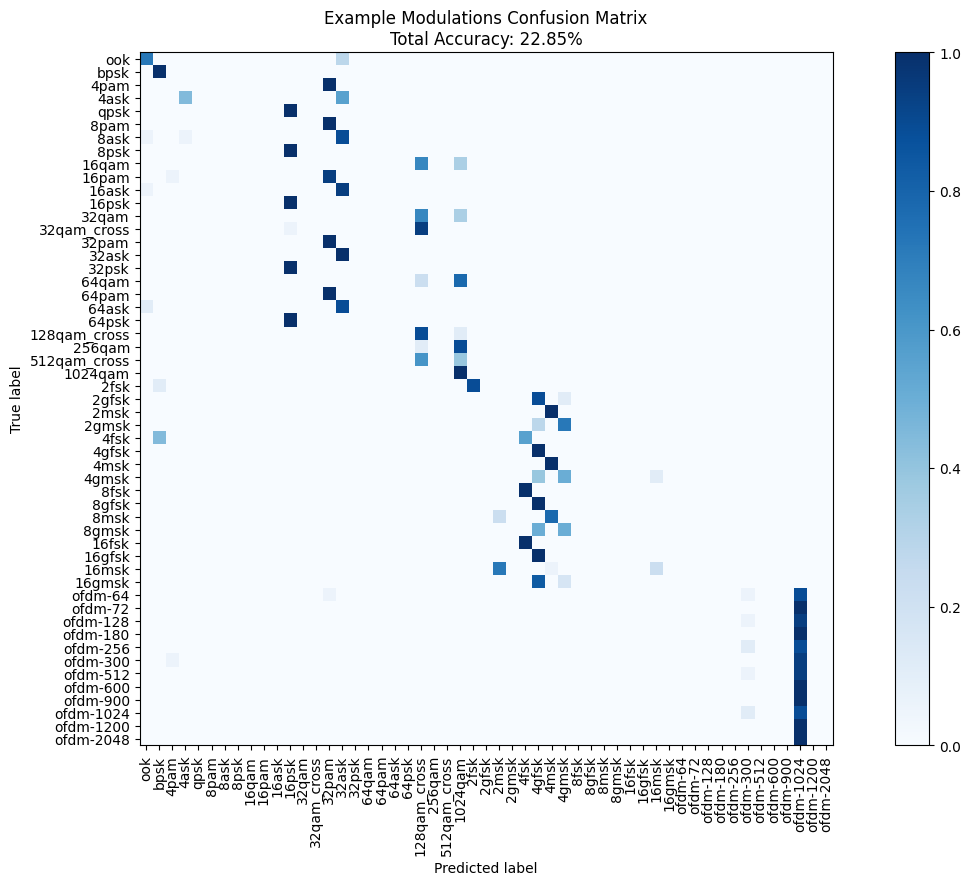

In [17]:
acc = np.sum(np.asarray(y_preds)==np.asarray(y_true))/len(y_true)
plot_confusion_matrix(
    y_true,
    y_preds,
    classes=class_list,
    normalize=True,
    title="Example Modulations Confusion Matrix\nTotal Accuracy: {:.2f}%".format(acc*100),
    text=False,
    rotate_x_text=90,
    figsize=(16,9),
)
plt.show()

In [18]:
print("Classification Report:")
print(classification_report(y_true, y_preds))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.72      0.74        18
         1.0       0.64      1.00      0.78        18
         2.0       0.00      0.00      0.00        18
         3.0       0.89      0.44      0.59        18
         4.0       0.00      0.00      0.00        18
         5.0       0.00      0.00      0.00        18
         6.0       0.00      0.00      0.00        18
         7.0       0.00      0.00      0.00        18
         8.0       0.00      0.00      0.00        18
         9.0       0.00      0.00      0.00        18
        10.0       0.00      0.00      0.00        18
        11.0       0.20      1.00      0.33        18
        12.0       0.00      0.00      0.00        18
        13.0       0.00      0.00      0.00        18
        14.0       0.20      1.00      0.33        18
        15.0       0.22      1.00      0.36        18
        16.0       0.00      0.00      0.00        18
    

/home/mutaz/.pyenv/versions/3.9.16/envs/torchsig/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mutaz/.pyenv/versions/3.9.16/envs/torchsig/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mutaz/.pyenv/versions/3.9.16/envs/torchsig/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [19]:
from typing import Dict

class_family_dict: Dict[str, str] = {
        "4ask": "ask",
        "8ask": "ask",
        "16ask": "ask",
        "32ask": "ask",
        "64ask": "ask",
        "ook": "pam",
        "4pam": "pam",
        "8pam": "pam",
        "16pam": "pam",
        "32pam": "pam",
        "64pam": "pam",
        "2fsk": "fsk",
        "2gfsk": "fsk",
        "2msk": "fsk",
        "2gmsk": "fsk",
        "4fsk": "fsk",
        "4gfsk": "fsk",
        "4msk": "fsk",
        "4gmsk": "fsk",
        "8fsk": "fsk",
        "8gfsk": "fsk",
        "8msk": "fsk",
        "8gmsk": "fsk",
        "16fsk": "fsk",
        "16gfsk": "fsk",
        "16msk": "fsk",
        "16gmsk": "fsk",
        "bpsk": "psk",
        "qpsk": "psk",
        "8psk": "psk",
        "16psk": "psk",
        "32psk": "psk",
        "64psk": "psk",
        "16qam": "qam",
        "32qam": "qam",
        "32qam_cross": "qam",
        "64qam": "qam",
        "128qam_cross": "qam",
        "256qam": "qam",
        "512qam_cross": "qam",
        "1024qam": "qam",
        "ofdm-64": "ofdm",
        "ofdm-72": "ofdm",
        "ofdm-128": "ofdm",
        "ofdm-180": "ofdm",
        "ofdm-256": "ofdm",
        "ofdm-300": "ofdm",
        "ofdm-512": "ofdm",
        "ofdm-600": "ofdm",
        "ofdm-900": "ofdm",
        "ofdm-1024": "ofdm",
        "ofdm-1200": "ofdm",
        "ofdm-2048": "ofdm",
    }

100%|██████████| 954/954 [00:24<00:00, 39.59it/s]


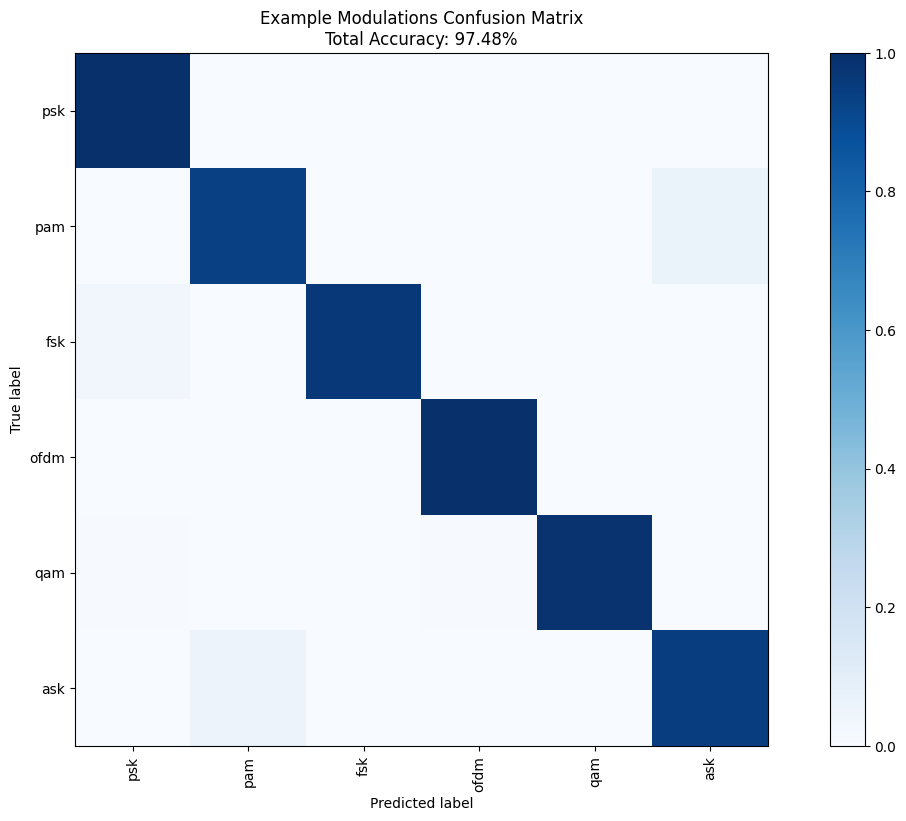

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95       108
         1.0       0.95      0.94      0.94       108
         2.0       1.00      0.97      0.98       288
         3.0       1.00      1.00      1.00       216
         4.0       1.00      0.99      0.99       144
         5.0       0.92      0.94      0.93        90

    accuracy                           0.97       954
   macro avg       0.96      0.97      0.97       954
weighted avg       0.98      0.97      0.98       954



In [20]:
num_families = len(set(class_family_dict.values()))

# Updated mappings
y_family_preds = np.empty((num_test_examples,))
y_family_true = np.empty((num_test_examples,))

for i in tqdm(range(0, num_test_examples)):
    # Retrieve data
    idx = i
    data, label = sig53_clean_val[idx]
    # Infer
    data = torch.from_numpy(np.expand_dims(data, 0)).float()
    data = data.cuda() if torch.cuda.is_available() else data
    pred_tmp = example_model.predict(data)
    pred_tmp = pred_tmp.cpu().numpy() if torch.cuda.is_available() else pred_tmp
    # Argmax and map to family
    pred_class = np.argmax(pred_tmp)
    pred_family = class_family_dict.get(Sig53._idx_to_name_dict[pred_class], 'unknown')
    true_family = class_family_dict.get(Sig53._idx_to_name_dict[label], 'unknown')
    # Skip if 'unknown'
    if pred_family == 'unknown' or true_family == 'unknown':
        continue
    y_family_preds[i] = list(set(class_family_dict.values())).index(pred_family)
    y_family_true[i] = list(set(class_family_dict.values())).index(true_family)

acc = np.sum(y_family_preds == y_family_true) / len(y_family_true)
family_list = list(set(class_family_dict.values()))

plot_confusion_matrix(
    y_family_true,
    y_family_preds,
    classes=family_list,
    normalize=True,
    title="Example Modulations Confusion Matrix\nTotal Accuracy: {:.2f}%".format(acc*100),
    text=False,
    rotate_x_text=90,
    figsize=(16,9),
)
plt.show()

print("Classification Report:")
print(classification_report(y_family_true, y_family_preds))

## EfficientNet B2

In [21]:
from torchsig.models.iq_models.efficientnet.efficientnet import efficientnet_b2

model = efficientnet_b2(
    pretrained=False,
    path="efficientnet_b2.pt",
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

example_model = ExampleNetwork(model, train_dataloader, val_dataloader)


# Setup checkpoint callbacks
checkpoint_filename = "{}/checkpoints/checkpoint".format(os.getcwd())
checkpoint_callback = ModelCheckpoint(
    filename=checkpoint_filename,
    save_top_k=True,
    monitor="val_loss",
    mode="min",
)

# Create and fit trainer
epochs = 25
trainer = Trainer(
    max_epochs=epochs, callbacks=checkpoint_callback, accelerator="gpu", devices=1
)
trainer.fit(example_model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type         | Params
--------------------------------------
0 | mdl  | EfficientNet | 7.6 M 
--------------------------------------
7.6 M     Trainable params
0         Non-trainable params
7.6 M     Total params
30.370    Total estimated model params size (MB)


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 11.11it/s]

/home/mutaz/.pyenv/versions/3.9.16/envs/torchsig/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 24: 100%|██████████| 16/16 [00:02<00:00,  5.36it/s, v_num=44, val_loss=2.040]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 16/16 [00:03<00:00,  4.76it/s, v_num=44, val_loss=2.040]


100%|██████████| 954/954 [00:17<00:00, 54.84it/s]


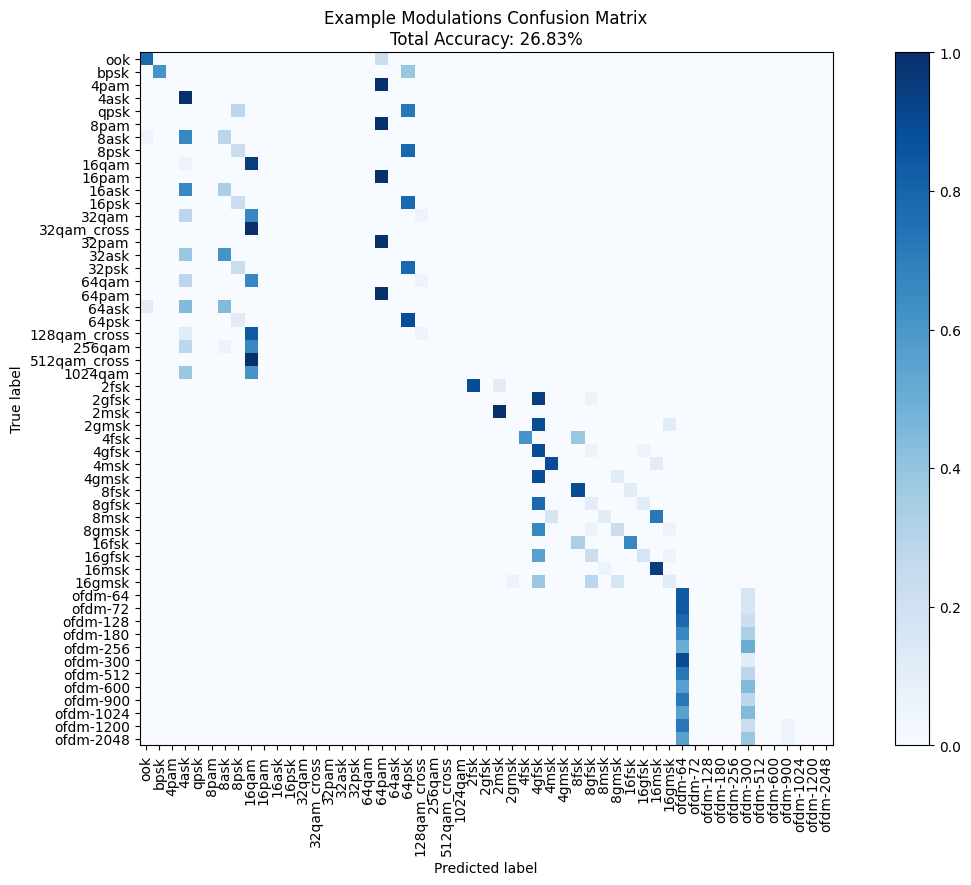

Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.78      0.80        18
         1.0       1.00      0.61      0.76        18
         2.0       0.00      0.00      0.00        18
         3.0       0.22      1.00      0.36        18
         4.0       0.00      0.00      0.00        18
         5.0       0.00      0.00      0.00        18
         6.0       0.16      0.28      0.20        18
         7.0       0.21      0.22      0.22        18
         8.0       0.15      0.94      0.26        18
         9.0       0.00      0.00      0.00        18
        10.0       0.00      0.00      0.00        18
        11.0       0.00      0.00      0.00        18
        12.0       0.00      0.00      0.00        18
        13.0       0.00      0.00      0.00        18
        14.0       0.00      0.00      0.00        18
        15.0       0.00      0.00      0.00        18
        16.0       0.00      0.00      0.00        18
    

/home/mutaz/.pyenv/versions/3.9.16/envs/torchsig/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mutaz/.pyenv/versions/3.9.16/envs/torchsig/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mutaz/.pyenv/versions/3.9.16/envs/torchsig/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [22]:
# Load best checkpoint
checkpoint = torch.load(checkpoint_filename+".ckpt", map_location=lambda storage, loc: storage)
example_model.load_state_dict(checkpoint["state_dict"], strict=False)
example_model = example_model.eval()
example_model = example_model.cuda() if torch.cuda.is_available() else example_model

# Infer results over validation set
num_test_examples = len(sig53_clean_val)
num_classes = len(list(Sig53._idx_to_name_dict.values()))
y_raw_preds = np.empty((num_test_examples,num_classes))
y_preds = np.zeros((num_test_examples,))
y_true = np.zeros((num_test_examples,))

for i in tqdm(range(0,num_test_examples)):
    # Retrieve data
    idx = i # Use index if evaluating over full dataset
    data, label = sig53_clean_val[idx]
    # Infer
    data = torch.from_numpy(np.expand_dims(data,0)).float()
    data = data.cuda() if torch.cuda.is_available() else data
    pred_tmp = example_model.predict(data)
    pred_tmp = pred_tmp.cpu().numpy() if torch.cuda.is_available() else pred_tmp
    # Argmax
    y_preds[i] = np.argmax(pred_tmp)
    # Store label
    y_true[i] = label


acc = np.sum(np.asarray(y_preds)==np.asarray(y_true))/len(y_true)
plot_confusion_matrix(
    y_true,
    y_preds,
    classes=class_list,
    normalize=True,
    title="Example Modulations Confusion Matrix\nTotal Accuracy: {:.2f}%".format(acc*100),
    text=False,
    rotate_x_text=90,
    figsize=(16,9),
)
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_preds))

100%|██████████| 954/954 [00:00<00:00, 213542.85it/s]


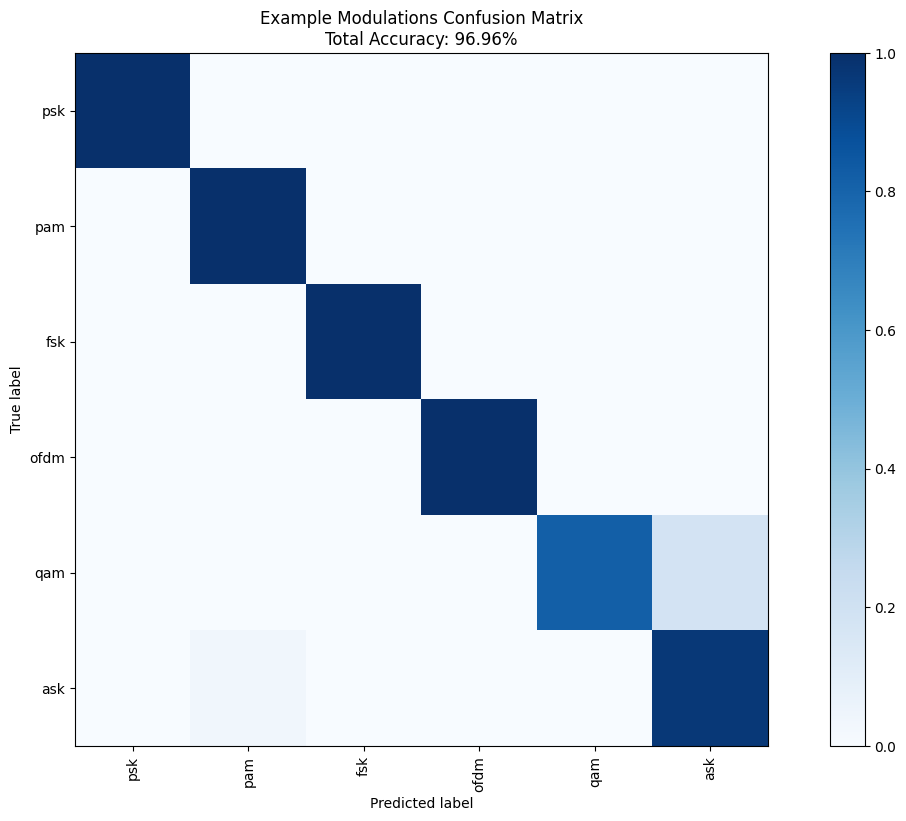

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       108
         1.0       0.97      1.00      0.99       108
         2.0       1.00      1.00      1.00       288
         3.0       1.00      1.00      1.00       216
         4.0       1.00      0.82      0.90       144
         5.0       0.77      0.97      0.86        90

    accuracy                           0.97       954
   macro avg       0.96      0.96      0.96       954
weighted avg       0.98      0.97      0.97       954



In [23]:
num_families = len(set(class_family_dict.values()))

# Updated mappings
y_family_preds = np.empty((num_test_examples,))
y_family_true = np.empty((num_test_examples,))

for i in tqdm(range(0, num_test_examples)):
    pred_class = int(y_preds[i])  # Using predictions from the first block
    true_class = int(y_true[i])   # Using true labels from the first block

    # Map to family
    pred_family = class_family_dict.get(Sig53._idx_to_name_dict[pred_class], 'unknown')
    true_family = class_family_dict.get(Sig53._idx_to_name_dict[true_class], 'unknown')

    # Skip if 'unknown'
    if pred_family == 'unknown' or true_family == 'unknown':
        continue

    y_family_preds[i] = list(set(class_family_dict.values())).index(pred_family)
    y_family_true[i] = list(set(class_family_dict.values())).index(true_family)

# Calculate accuracy
acc = np.sum(y_family_preds == y_family_true) / len(y_family_true)
family_list = list(set(class_family_dict.values()))

# Plot confusion matrix
plot_confusion_matrix(
    y_family_true,
    y_family_preds,
    classes=family_list,
    normalize=True,
    title="Example Modulations Confusion Matrix\nTotal Accuracy: {:.2f}%".format(acc*100),
    text=False,
    rotate_x_text=90,
    figsize=(16,9),
)
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_family_true, y_family_preds))

## EfficientNet B0

In [24]:
from torchsig.models.iq_models.efficientnet.efficientnet import efficientnet_b0

model = efficientnet_b0(
    pretrained=False,
    path="efficientnet_b0.pt",
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

example_model = ExampleNetwork(model, train_dataloader, val_dataloader)


# Setup checkpoint callbacks
checkpoint_filename = "{}/checkpoints/checkpoint".format(os.getcwd())
checkpoint_callback = ModelCheckpoint(
    filename=checkpoint_filename,
    save_top_k=True,
    monitor="val_loss",
    mode="min",
)

# Create and fit trainer
epochs = 25
trainer = Trainer(
    max_epochs=epochs, callbacks=checkpoint_callback, accelerator="gpu", devices=1
)
trainer.fit(example_model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type         | Params
--------------------------------------
0 | mdl  | EfficientNet | 4.0 M 
--------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.813    Total estimated model params size (MB)


/home/mutaz/.pyenv/versions/3.9.16/envs/torchsig/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 24: 100%|██████████| 16/16 [00:02<00:00,  6.58it/s, v_num=45, val_loss=1.950]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 16/16 [00:02<00:00,  6.57it/s, v_num=45, val_loss=1.950]


  0%|          | 0/954 [00:00<?, ?it/s]

100%|██████████| 954/954 [00:12<00:00, 76.03it/s]


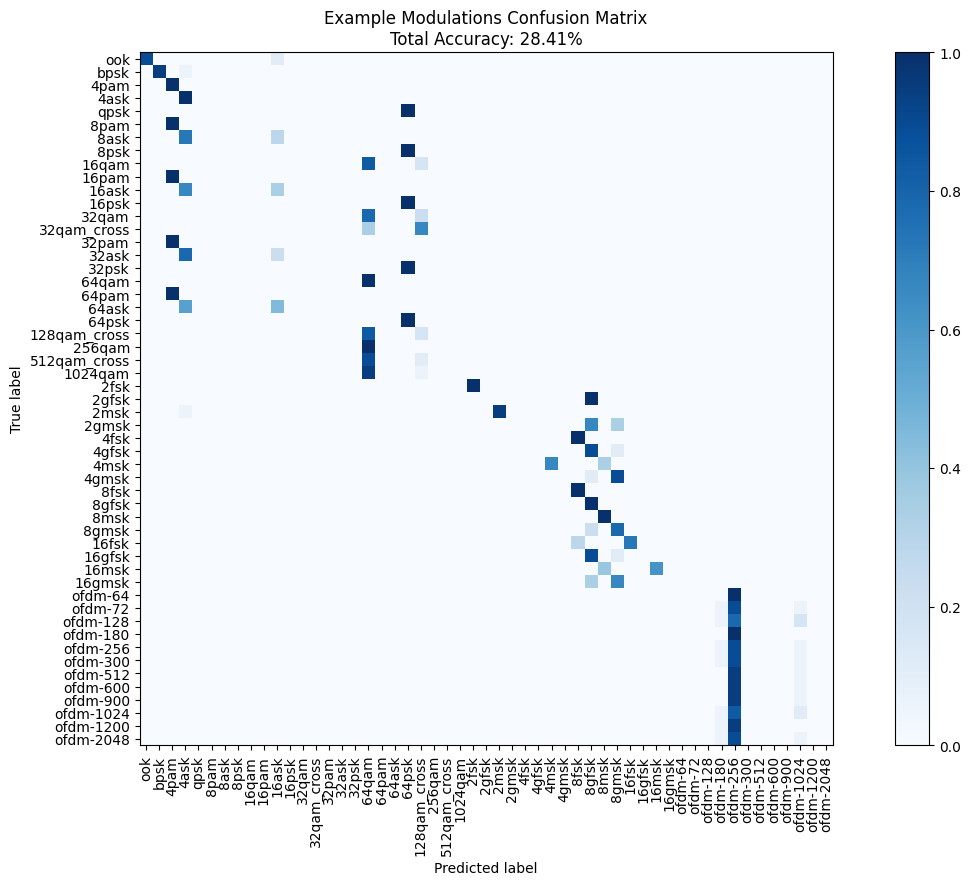

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94        18
         1.0       1.00      0.94      0.97        18
         2.0       0.20      1.00      0.33        18
         3.0       0.26      1.00      0.41        18
         4.0       0.00      0.00      0.00        18
         5.0       0.00      0.00      0.00        18
         6.0       0.00      0.00      0.00        18
         7.0       0.00      0.00      0.00        18
         8.0       0.00      0.00      0.00        18
         9.0       0.00      0.00      0.00        18
        10.0       0.24      0.33      0.28        18
        11.0       0.00      0.00      0.00        18
        12.0       0.00      0.00      0.00        18
        13.0       0.00      0.00      0.00        18
        14.0       0.00      0.00      0.00        18
        15.0       0.00      0.00      0.00        18
        16.0       0.00      0.00      0.00        18
    

/home/mutaz/.pyenv/versions/3.9.16/envs/torchsig/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mutaz/.pyenv/versions/3.9.16/envs/torchsig/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mutaz/.pyenv/versions/3.9.16/envs/torchsig/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [25]:
# Load best checkpoint
checkpoint = torch.load(checkpoint_filename+".ckpt", map_location=lambda storage, loc: storage)
example_model.load_state_dict(checkpoint["state_dict"], strict=False)
example_model = example_model.eval()
example_model = example_model.cuda() if torch.cuda.is_available() else example_model

# Infer results over validation set
num_test_examples = len(sig53_clean_val)
num_classes = len(list(Sig53._idx_to_name_dict.values()))
y_raw_preds = np.empty((num_test_examples,num_classes))
y_preds = np.zeros((num_test_examples,))
y_true = np.zeros((num_test_examples,))

for i in tqdm(range(0,num_test_examples)):
    # Retrieve data
    idx = i # Use index if evaluating over full dataset
    data, label = sig53_clean_val[idx]
    # Infer
    data = torch.from_numpy(np.expand_dims(data,0)).float()
    data = data.cuda() if torch.cuda.is_available() else data
    pred_tmp = example_model.predict(data)
    pred_tmp = pred_tmp.cpu().numpy() if torch.cuda.is_available() else pred_tmp
    # Argmax
    y_preds[i] = np.argmax(pred_tmp)
    # Store label
    y_true[i] = label


acc = np.sum(np.asarray(y_preds)==np.asarray(y_true))/len(y_true)
plot_confusion_matrix(
    y_true,
    y_preds,
    classes=class_list,
    normalize=True,
    title="Example Modulations Confusion Matrix\nTotal Accuracy: {:.2f}%".format(acc*100),
    text=False,
    rotate_x_text=90,
    figsize=(16,9),
)
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_preds))

100%|██████████| 954/954 [00:00<00:00, 213281.06it/s]


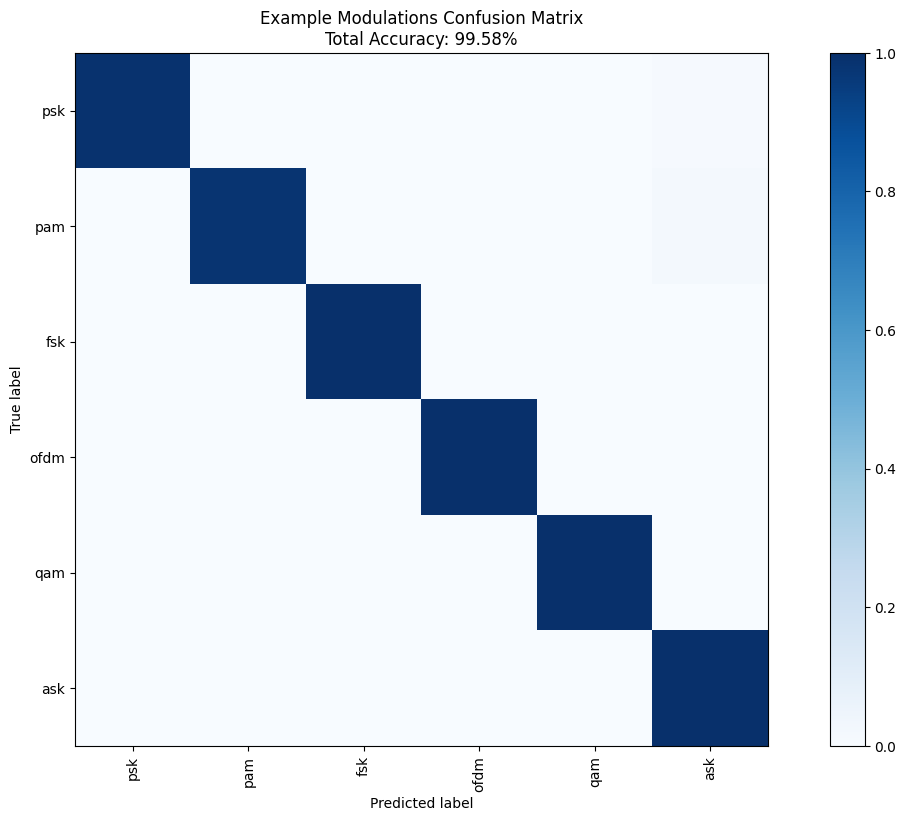

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       108
         1.0       1.00      0.98      0.99       108
         2.0       1.00      1.00      1.00       288
         3.0       1.00      1.00      1.00       216
         4.0       1.00      1.00      1.00       144
         5.0       0.96      1.00      0.98        90

    accuracy                           1.00       954
   macro avg       0.99      0.99      0.99       954
weighted avg       1.00      1.00      1.00       954



In [26]:
num_families = len(set(class_family_dict.values()))

# Updated mappings
y_family_preds = np.empty((num_test_examples,))
y_family_true = np.empty((num_test_examples,))

for i in tqdm(range(0, num_test_examples)):
    pred_class = int(y_preds[i])  # Using predictions from the first block
    true_class = int(y_true[i])   # Using true labels from the first block

    # Map to family
    pred_family = class_family_dict.get(Sig53._idx_to_name_dict[pred_class], 'unknown')
    true_family = class_family_dict.get(Sig53._idx_to_name_dict[true_class], 'unknown')

    # Skip if 'unknown'
    if pred_family == 'unknown' or true_family == 'unknown':
        continue

    y_family_preds[i] = list(set(class_family_dict.values())).index(pred_family)
    y_family_true[i] = list(set(class_family_dict.values())).index(true_family)

# Calculate accuracy
acc = np.sum(y_family_preds == y_family_true) / len(y_family_true)
family_list = list(set(class_family_dict.values()))

# Plot confusion matrix
plot_confusion_matrix(
    y_family_true,
    y_family_preds,
    classes=family_list,
    normalize=True,
    title="Example Modulations Confusion Matrix\nTotal Accuracy: {:.2f}%".format(acc*100),
    text=False,
    rotate_x_text=90,
    figsize=(16,9),
)
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_family_true, y_family_preds))

## XCiT Nano

In [27]:
# Create dataloaders
train_dataloader = DataLoader(
    dataset=sig53_clean_train,
    batch_size=1,
    num_workers=8,
    shuffle=True,
    drop_last=True,
)
val_dataloader = DataLoader(
    dataset=sig53_clean_val,
    batch_size=1,
    num_workers=8,
    shuffle=False,
    drop_last=True,
)

In [28]:
from torchsig.models.iq_models.xcit.xcit import xcit_nano

model = xcit_nano(
    pretrained=False,
    path="xcit_nano.pt",
)

In [29]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

example_model = ExampleNetwork(model, train_dataloader, val_dataloader)

# Setup checkpoint callbacks
checkpoint_filename = "{}/checkpoints/checkpoint".format(os.getcwd())
checkpoint_callback = ModelCheckpoint(
    filename=checkpoint_filename,
    save_top_k=True,
    monitor="val_loss",
    mode="min",
)

# Create and fit trainer
epochs = 25
trainer = Trainer(
    max_epochs=epochs, callbacks=checkpoint_callback, accelerator="gpu", devices=1
)
trainer.fit(example_model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | mdl  | XCiT | 2.9 M 
------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.434    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/mutaz/.pyenv/versions/3.9.16/envs/torchsig/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 24: 100%|██████████| 16/16 [00:20<00:00,  0.80it/s, v_num=46, val_loss=4.170]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 16/16 [00:20<00:00,  0.79it/s, v_num=46, val_loss=4.170]


100%|██████████| 954/954 [00:15<00:00, 61.24it/s]


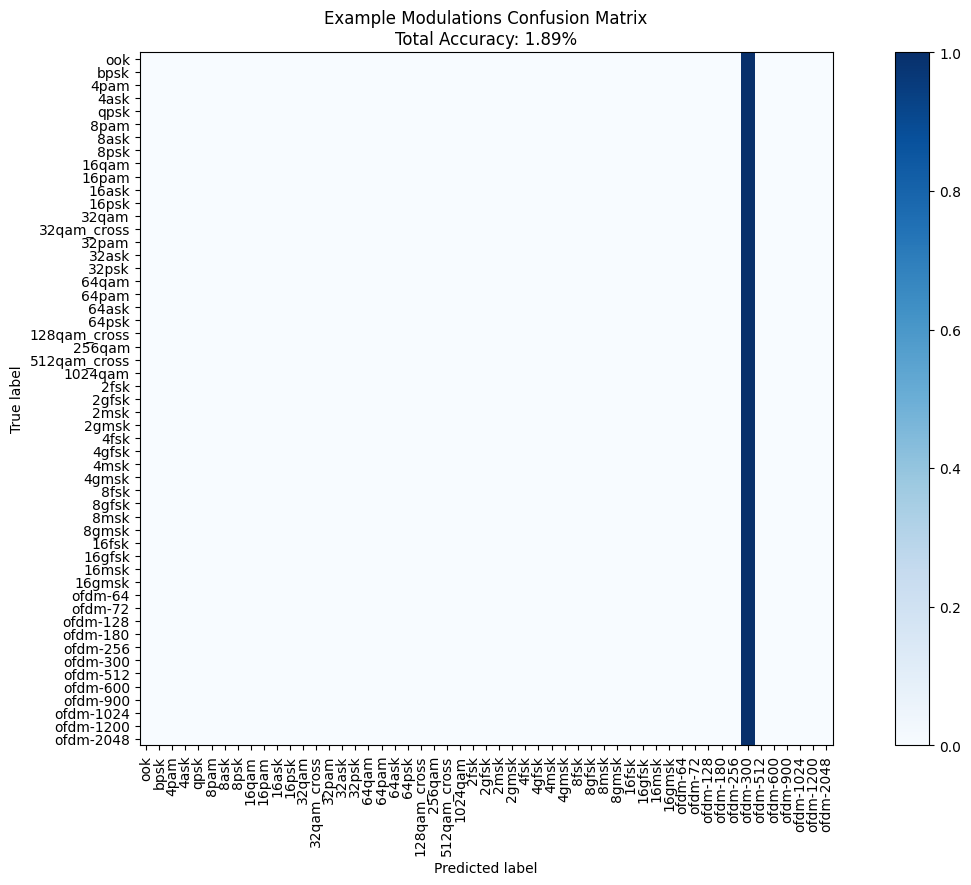

Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        18
         1.0       0.00      0.00      0.00        18
         2.0       0.00      0.00      0.00        18
         3.0       0.00      0.00      0.00        18
         4.0       0.00      0.00      0.00        18
         5.0       0.00      0.00      0.00        18
         6.0       0.00      0.00      0.00        18
         7.0       0.00      0.00      0.00        18
         8.0       0.00      0.00      0.00        18
         9.0       0.00      0.00      0.00        18
        10.0       0.00      0.00      0.00        18
        11.0       0.00      0.00      0.00        18
        12.0       0.00      0.00      0.00        18
        13.0       0.00      0.00      0.00        18
        14.0       0.00      0.00      0.00        18
        15.0       0.00      0.00      0.00        18
        16.0       0.00      0.00      0.00        18
    

/home/mutaz/.pyenv/versions/3.9.16/envs/torchsig/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mutaz/.pyenv/versions/3.9.16/envs/torchsig/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mutaz/.pyenv/versions/3.9.16/envs/torchsig/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [30]:
# Load best checkpoint
checkpoint = torch.load(checkpoint_filename+".ckpt", map_location=lambda storage, loc: storage)
example_model.load_state_dict(checkpoint["state_dict"], strict=False)
example_model = example_model.eval()
example_model = example_model.cuda() if torch.cuda.is_available() else example_model

# Infer results over validation set
num_test_examples = len(sig53_clean_val)
num_classes = len(list(Sig53._idx_to_name_dict.values()))
y_raw_preds = np.empty((num_test_examples,num_classes))
y_preds = np.zeros((num_test_examples,))
y_true = np.zeros((num_test_examples,))

for i in tqdm(range(0,num_test_examples)):
    # Retrieve data
    idx = i # Use index if evaluating over full dataset
    data, label = sig53_clean_val[idx]
    # Infer
    data = torch.from_numpy(np.expand_dims(data,0)).float()
    data = data.cuda() if torch.cuda.is_available() else data
    pred_tmp = example_model.predict(data)
    pred_tmp = pred_tmp.cpu().numpy() if torch.cuda.is_available() else pred_tmp
    # Argmax
    y_preds[i] = np.argmax(pred_tmp)
    # Store label
    y_true[i] = label


acc = np.sum(np.asarray(y_preds)==np.asarray(y_true))/len(y_true)
plot_confusion_matrix(
    y_true,
    y_preds,
    classes=class_list,
    normalize=True,
    title="Example Modulations Confusion Matrix\nTotal Accuracy: {:.2f}%".format(acc*100),
    text=False,
    rotate_x_text=90,
    figsize=(16,9),
)
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_preds))

In [31]:
print(example_model)

ExampleNetwork(
  (mdl): XCiT(
    (backbone): XCiT(
      (patch_embed): ConvDownSampler(
        (blocks): Sequential(
          (0): Conv1d(2, 128, kernel_size=(5,), stride=(2,), padding=(2,))
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU()
          (3): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
        )
      )
      (pos_embed): PositionalEncodingFourier(
        (token_projection): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      )
      (pos_drop): Dropout(p=0.3, inplace=False)
      (blocks): ModuleList(
        (0-11): 12 x XCABlock(
          (norm1): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (attn): XCA(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.3, inplace=False)
          )
  

100%|██████████| 954/954 [00:00<00:00, 213508.67it/s]


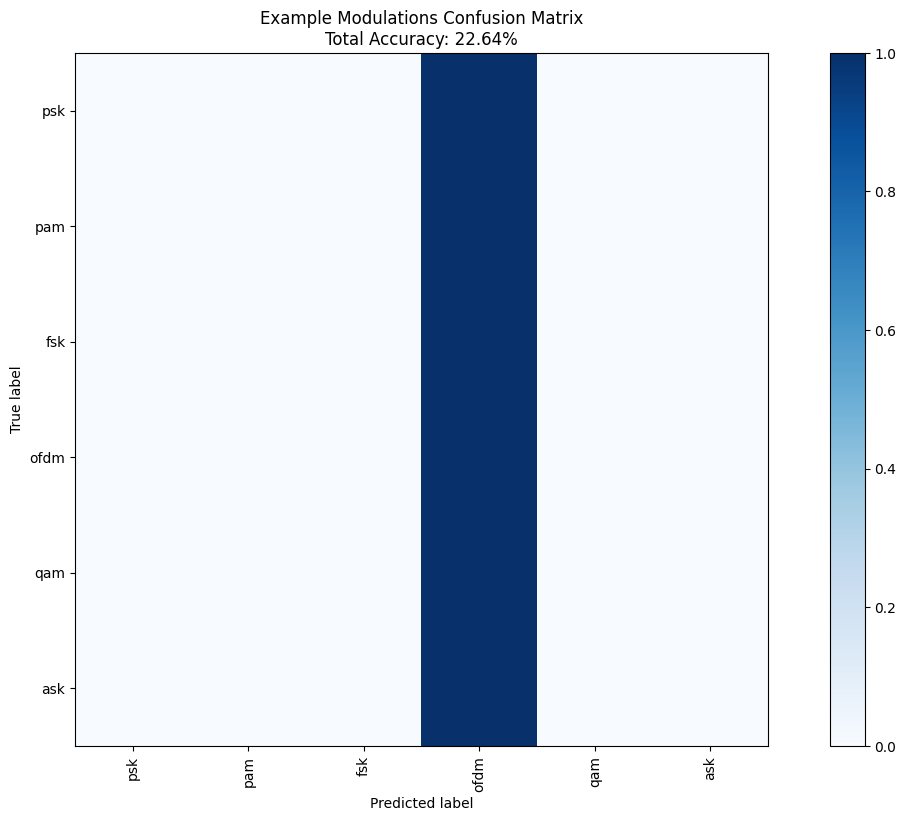

Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       108
         1.0       0.00      0.00      0.00       108
         2.0       0.00      0.00      0.00       288
         3.0       0.23      1.00      0.37       216
         4.0       0.00      0.00      0.00       144
         5.0       0.00      0.00      0.00        90

    accuracy                           0.23       954
   macro avg       0.04      0.17      0.06       954
weighted avg       0.05      0.23      0.08       954



/home/mutaz/.pyenv/versions/3.9.16/envs/torchsig/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mutaz/.pyenv/versions/3.9.16/envs/torchsig/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mutaz/.pyenv/versions/3.9.16/envs/torchsig/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [32]:
num_families = len(set(class_family_dict.values()))

# Updated mappings
y_family_preds = np.empty((num_test_examples,))
y_family_true = np.empty((num_test_examples,))

for i in tqdm(range(0, num_test_examples)):
    pred_class = int(y_preds[i])  # Using predictions from the first block
    true_class = int(y_true[i])   # Using true labels from the first block

    # Map to family
    pred_family = class_family_dict.get(Sig53._idx_to_name_dict[pred_class], 'unknown')
    true_family = class_family_dict.get(Sig53._idx_to_name_dict[true_class], 'unknown')

    # Skip if 'unknown'
    if pred_family == 'unknown' or true_family == 'unknown':
        continue

    y_family_preds[i] = list(set(class_family_dict.values())).index(pred_family)
    y_family_true[i] = list(set(class_family_dict.values())).index(true_family)

# Calculate accuracy
acc = np.sum(y_family_preds == y_family_true) / len(y_family_true)
family_list = list(set(class_family_dict.values()))

# Plot confusion matrix
plot_confusion_matrix(
    y_family_true,
    y_family_preds,
    classes=family_list,
    normalize=True,
    title="Example Modulations Confusion Matrix\nTotal Accuracy: {:.2f}%".format(acc*100),
    text=False,
    rotate_x_text=90,
    figsize=(16,9),
)
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_family_true, y_family_preds))

## XCiT Tiny 12

In [ ]:
from torchsig.models.iq_models.xcit.xcit import xcit_tiny12

model = xcit_tiny12(
    pretrained=False,
    path="xcit_tiny12.pt",
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Setup checkpoint callbacks
checkpoint_filename = "{}/checkpoints/checkpoint".format(os.getcwd())
checkpoint_callback = ModelCheckpoint(
    filename=checkpoint_filename,
    save_top_k=True,
    monitor="val_loss",
    mode="min",
)

# Create and fit trainer
epochs = 25
trainer = Trainer(
    max_epochs=epochs, callbacks=checkpoint_callback, accelerator="gpu", devices=1
)
trainer.fit(example_model)

In [ ]:
# Load best checkpoint
checkpoint = torch.load(checkpoint_filename+".ckpt", map_location=lambda storage, loc: storage)
example_model.load_state_dict(checkpoint["state_dict"], strict=False)
example_model = example_model.eval()
example_model = example_model.cuda() if torch.cuda.is_available() else example_model

# Infer results over validation set
num_test_examples = len(sig53_clean_val)
num_classes = len(list(Sig53._idx_to_name_dict.values()))
y_raw_preds = np.empty((num_test_examples,num_classes))
y_preds = np.zeros((num_test_examples,))
y_true = np.zeros((num_test_examples,))

for i in tqdm(range(0,num_test_examples)):
    # Retrieve data
    idx = i # Use index if evaluating over full dataset
    data, label = sig53_clean_val[idx]
    # Infer
    data = torch.from_numpy(np.expand_dims(data,0)).float()
    data = data.cuda() if torch.cuda.is_available() else data
    pred_tmp = example_model.predict(data)
    pred_tmp = pred_tmp.cpu().numpy() if torch.cuda.is_available() else pred_tmp
    # Argmax
    y_preds[i] = np.argmax(pred_tmp)
    # Store label
    y_true[i] = label


acc = np.sum(np.asarray(y_preds)==np.asarray(y_true))/len(y_true)
plot_confusion_matrix(
    y_true,
    y_preds,
    classes=class_list,
    normalize=True,
    title="Example Modulations Confusion Matrix\nTotal Accuracy: {:.2f}%".format(acc*100),
    text=False,
    rotate_x_text=90,
    figsize=(16,9),
)
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_preds))

100%|██████████| 954/954 [00:00<00:00, 220862.51it/s]


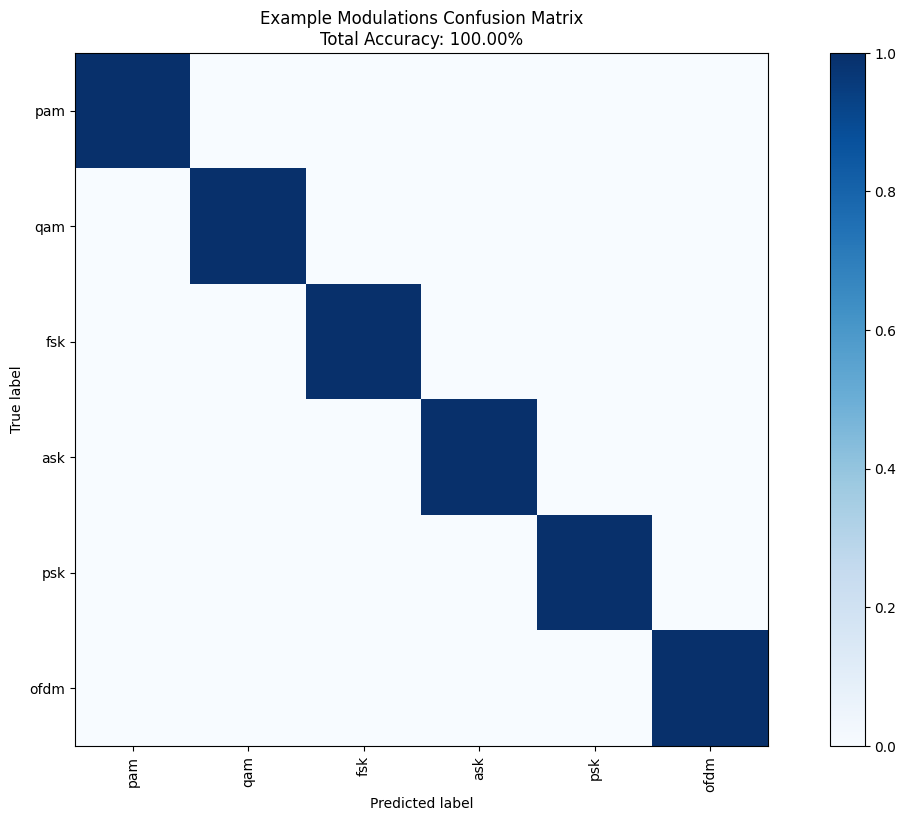

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       108
         1.0       1.00      1.00      1.00       144
         2.0       1.00      1.00      1.00       288
         3.0       1.00      1.00      1.00        90
         4.0       1.00      1.00      1.00       108
         5.0       1.00      1.00      1.00       216

    accuracy                           1.00       954
   macro avg       1.00      1.00      1.00       954
weighted avg       1.00      1.00      1.00       954



In [32]:
num_families = len(set(class_family_dict.values()))

# Updated mappings
y_family_preds = np.empty((num_test_examples,))
y_family_true = np.empty((num_test_examples,))

for i in tqdm(range(0, num_test_examples)):
    pred_class = int(y_preds[i])  # Using predictions from the first block
    true_class = int(y_true[i])   # Using true labels from the first block

    # Map to family
    pred_family = class_family_dict.get(Sig53._idx_to_name_dict[pred_class], 'unknown')
    true_family = class_family_dict.get(Sig53._idx_to_name_dict[true_class], 'unknown')

    # Skip if 'unknown'
    if pred_family == 'unknown' or true_family == 'unknown':
        continue

    y_family_preds[i] = list(set(class_family_dict.values())).index(pred_family)
    y_family_true[i] = list(set(class_family_dict.values())).index(true_family)

# Calculate accuracy
acc = np.sum(y_family_preds == y_family_true) / len(y_family_true)
family_list = list(set(class_family_dict.values()))

# Plot confusion matrix
plot_confusion_matrix(
    y_family_true,
    y_family_preds,
    classes=family_list,
    normalize=True,
    title="Example Modulations Confusion Matrix\nTotal Accuracy: {:.2f}%".format(acc*100),
    text=False,
    rotate_x_text=90,
    figsize=(16,9),
)
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_family_true, y_family_preds))

In [ ]:
print(model)